In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from scipy.stats import norm, uniform
from copy import copy
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [3]:
X = pd.read_csv('mnist_data.csv').values[:, 1:]
y = pd.read_csv('mnist_target.csv').values[:, 1]

In [4]:
X = X / 255
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
class Data:
    def __init__(self, X, y):
        self.X = torch.Tensor(X).float()
        self.y = torch.Tensor(y).long()
        
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return self.X.shape[0]

In [6]:
dataset = Data(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
model = Net(X_train.shape[1])
model

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

Episode: 0 Loss: 486.68929901719093
Episode: 1 Loss: 169.74016864597797
Episode: 2 Loss: 134.13464929908514
Episode: 3 Loss: 120.26070345193148
Episode: 4 Loss: 110.69472658634186
Episode: 5 Loss: 103.2421403080225
Episode: 6 Loss: 96.65963277220726
Episode: 7 Loss: 91.21904148161411
Episode: 8 Loss: 85.30391281098127
Episode: 9 Loss: 80.15415497124195
Episode: 10 Loss: 75.7144473567605
Episode: 11 Loss: 71.58144890889525
Episode: 12 Loss: 67.34279996529222
Episode: 13 Loss: 63.86995845660567
Episode: 14 Loss: 60.47321620211005
Episode: 15 Loss: 57.21575204655528
Episode: 16 Loss: 54.41325965896249
Episode: 17 Loss: 51.53786788508296
Episode: 18 Loss: 48.97713580355048
Episode: 19 Loss: 46.69662443548441
Episode: 20 Loss: 44.44203654676676
Episode: 21 Loss: 42.40579508431256
Episode: 22 Loss: 40.725778417661786
Episode: 23 Loss: 38.678245689719915
Episode: 24 Loss: 36.90456669591367
Episode: 25 Loss: 35.428804283961654
Episode: 26 Loss: 33.883414125069976
Episode: 27 Loss: 32.658183995

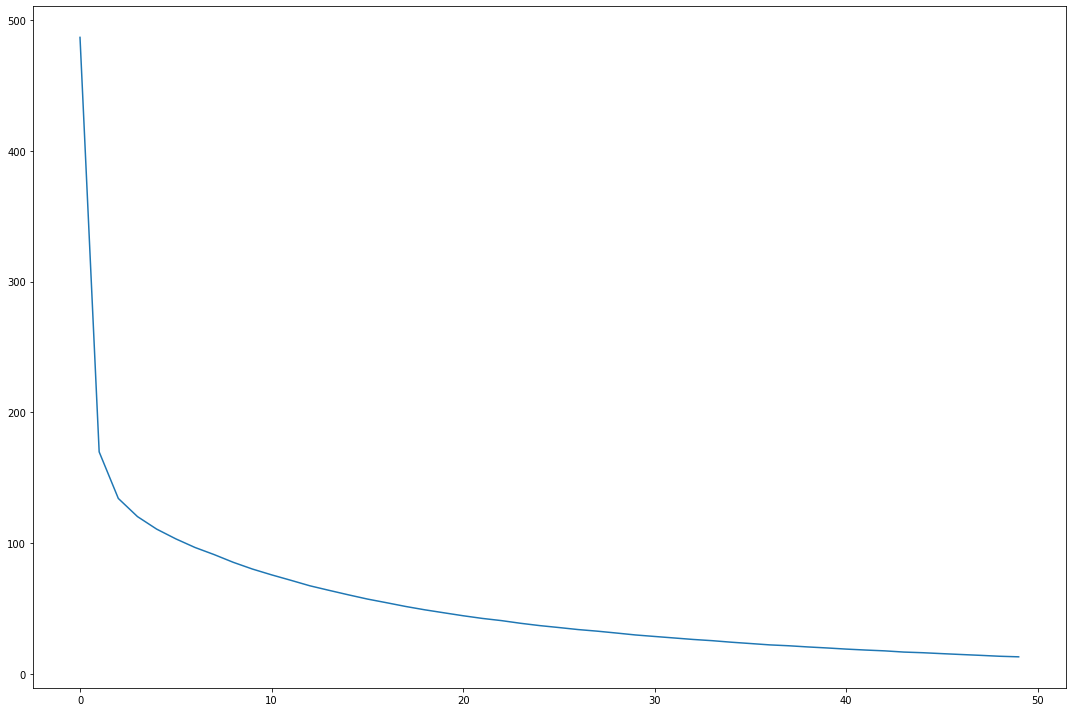

In [10]:
losses = []
epoch = 50
for i in range(epoch):
    sum_loss = 0
    for batch in iter(dataloader):
        X_, y_ = batch
        y_hat = model(X_)
        loss = loss_function(y_hat, y_.long())
        optim.zero_grad()
        loss.backward()
        optim.step()
        sum_loss += loss.item()
    losses.append(sum_loss)
    print("Episode:", i, "Loss:", sum_loss)

plt.figure(figsize=(15, 10))
plt.plot(list(range(epoch)), losses)
plt.tight_layout()
plt.show()

In [11]:
def predict(X):
    X = torch.Tensor(X).float()
    y_hat = F.softmax(model(X)).detach().numpy()
    return np.argmax(y_hat, axis=1)

In [12]:
print("точность на тесте =", np.sum(predict(X_test) == y_test) / len(y_test))

точность на тесте = 0.9722857142857143


C:\Users\Alina\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
def fast_adversarial_example(dig, n=784, n_classes=10, eta=0.01, iters=10):
    y = torch.tensor([dig]).long()
    x = torch.tensor(np.random.normal(loc=0, scale=0.01, size=n)).float()
    for _ in range(iters):
        # write your code here (start)      
        x = Variable(x.data.clone(), requires_grad=True)
        y_hat = model(x).unsqueeze(0)
        loss = loss_function(y_hat,y)
        model.zero_grad()
        loss.backward()
        grad = x.grad.data
        x = torch.clamp(x - eta*grad.sign(), 0, 1)
        # write your code here (end)
    return x

In [14]:
example = fast_adversarial_example(8, eta=0.1, iters=5)

In [15]:
alpha = 0.5
X_spoiled = np.maximum(X_test*(1-alpha), alpha*example.detach().numpy())
y_test_model = predict(X_spoiled)

C:\Users\Alina\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
print("точность после атаки =", np.sum(predict(X_spoiled) == y_test) / len(y_test))

точность после атаки = 0.09908571428571429


C:\Users\Alina\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
